Studying the symmetric regularization for repulsion/clustering

In [33]:
import numpy as np
from sklearn import datasets, mixture
from src.embedding import BaseEmb
from src.filter_approx import Heat_filter
from src.dataset import SwissRoll
import matplotlib.pyplot as plt
from typing import Union
from src.utils import interpolate, time_entropy, get_optimal_heat


In [48]:
class new_HeatGeo(BaseEmb):
    def __init__(
        self,
        knn: int,
        anisotropy: int = 0,
        decay: int = 40,
        n_pca: int = 40,
        tau: int = 10,
        emb_dim: int = 2,
        filter_method: str = "pygsp",
        order: int = 32,
        lap_type: str = "normalized",
        tau_min: float = 0.1,
        tau_max: float = 200,
        n_tau: int = 1,
        log_normalize: bool = False,
        scale_factor: float = 1.0,
        denoising: bool = False,
        n_ref: int = 50,
        n_svd: int = 50,
        graph_type: str = "alpha",
        truncation_type: Union[str,None] = None,
        truncation_arg: Union[str,None] = None,
        treshold_type: str = "min", # "min" or "max"
        harnack_regul: float = 0,  #Harnack regularization parameter, between 0 and 1.
        norm_treshold: bool = True,
    ):
        """
        truncation_type = None, heat_truncation (truncating the heat kernel)
            Cases : 
                - None : no truncation
                - "heat_truncation" : truncation of the heat kernel. In this case, the heat kernel is truncated such that all values below truncation_arg*max(heat_kernel) are set to 0.
                - "dist_truncation" : truncation of the distance matrix. In this case, the distance matrix is normalized to [0,1] and values above truncation_arg are set to 1.
        """
        super().__init__(
            knn,
            anisotropy,
            decay,
            n_pca,
            tau=tau,
            emb_dim=emb_dim,
            lap_type=lap_type,
            filter_method=filter_method,
            order=order,
            tau_min=tau_min,
            tau_max=tau_max,
            n_tau=n_tau,
            scale_factor=scale_factor,
            graph_type=graph_type
        )
        self.log_normalize = log_normalize
        self.n_ref = n_ref
        self.denoising = denoising
        self.n_svd = n_svd
        self._n_tau = n_tau
        self._tau_max = tau_max
        self.truncation_type = truncation_type
        self.truncation_arg = truncation_arg
        self.harnack_regul = harnack_regul
        self.treshold_type = treshold_type
        self.norm_treshold = norm_treshold

        #assert self.harnack_regul<=1 and self.harnack_regul>=0, "Harnack regularization parameter must be between 0 and 1."

    @property
    def n_tau(self):
        if self._n_tau == 1 and self.tau == "auto":
            return 10  # default value.
        else:
            return self._n_tau

    @property
    def tau_max(self):
        if self._tau_max == 1.0 and self.tau == "auto":
            return 50  # default value.
        else:
            return self._tau_max

    def metric_computation(self, data):
        N = self.graph.W.shape[0]
        eye = np.eye(N)
        
        if self.tau == "auto":
            heat_kernel, self.opt_tau, self.entro_H = get_optimal_heat(self, self.tau_max, self.n_tau)
            tau = [self.opt_tau]
        else:
            if (
            self.filter_method in ["pygsp", "mar"] and self.n_tau > 1
            ):  # NOTE: for Multiscale only works with pygsp and mar.
                tau = np.geomspace(self.tau_min, self.tau_max, self.n_tau)
            else:
                tau = [self.tau]

            filter = Heat_filter(self.graph, tau, self.order, self.filter_method)
            heat_kernel = filter(eye).reshape(N, N, -1)
            
            self.entro_H = time_entropy(heat_kernel)

        if self.truncation_type == "heat_truncation": # truncating the heat kernel directly.
                threshold = self.truncation_arg * heat_kernel.max()
                heat_kernel[heat_kernel < self.truncation_arg] = 0
        
        if len(heat_kernel.shape)==2: # NOTE currently works for (n_points,n_points,n_tau).
            heat_kernel = heat_kernel[:,:,np.newaxis]
        
        heat_kernel[heat_kernel < 0] = 0 # TODO: move this somewhere else.

        if self.log_normalize:
            # with the Euler method the diffusion time is really tau/order.
            den = (
                [t / self.order for t in tau]
                if self.filter_method == "euler"
                else tau
            )

            distance = [
                (np.log(heat_kernel[:, :, i] + 1e-16) / np.log(den[i] + 1e-16))
                ** self.scale_factor
                for i in range(len(tau))
            ]
        else:
              # NOTE/TODO: this could be default with a weight parameter to interpolate between the two.
            s_distance = [
                    (-4 * tau[i] * np.log(heat_kernel[:, :, i] + 1e-16))
                    + self.harnack_regul*(4 * tau[i])
                    * np.log(
                        (1 / 2)
                        * (
                            np.diag(heat_kernel[:, :, i])
                            + np.diag(heat_kernel[:, :, i]).reshape(-1, 1)
                        )
                        + 1e-16
                    )
                for i in range(len(tau))
            ]

            s_distance = np.array(s_distance)

            s_distance[s_distance < 0] = 0

            distance = np.sqrt(s_distance) ** self.scale_factor


        if self.n_tau > 1 and self.tau != "auto":
            weights = 1 - tau / tau.sum()
            w_t = weights.sum()
            weights = weights / w_t if w_t > 0 else None
        else:
            weights = None

        self.dist = np.average(distance, axis=0, weights=weights)

        if self.denoising:
            self.selective_denoising(self.dist)

        if self.truncation_type == "dist_truncation":
            if self.norm_treshold:
                self.dist = self.dist - self.dist.min()
                self.dist = self.dist / self.dist.max()
                assert (self.dist - self.dist.T).max() < 1e-10 # checking almost symmetric matrix.
                if self.treshold_type == "max":
                    self.dist[self.dist > self.truncation_arg] = 1
                elif self.treshold_type == "min":
                    self.dist[self.dist < self.truncation_arg] = 0
                self.dist = np.maximum(self.dist, self.dist.T)
            else:
                dist_min = self.dist.min()
                dist_max = self.dist.max()
                qt = np.quantile(self.dist, self.truncation_arg)
                assert (self.dist - self.dist.T).max() < 1e-10 # checking almost symmetric matrix.
                if self.treshold_type == "max":
                    self.dist[self.dist > qt] = dist_max
                elif self.treshold_type == "min":
                    self.dist[self.dist < qt] = dist_min
                self.dist = np.maximum(self.dist, self.dist.T)

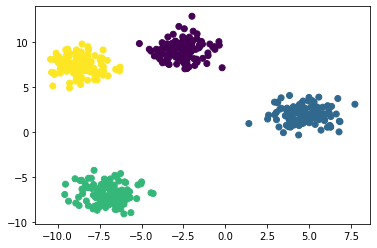

In [3]:
data, labels = datasets.make_blobs(n_samples=500,n_features=2, centers=4, random_state=42)
plt.scatter(data[:,0],data[:,1],c=labels)

/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


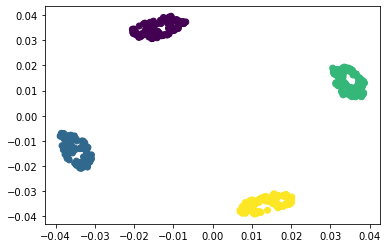

In [5]:
truncation_type = "dist_truncation"
truncation_arg = 0.8
emb_op = new_HeatGeo(knn=5, tau="auto", truncation_type=truncation_type, truncation_arg=truncation_arg)
emb = emb_op.fit_transform(data)
plt.scatter(emb[:,0],emb[:,1],c=labels)

/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


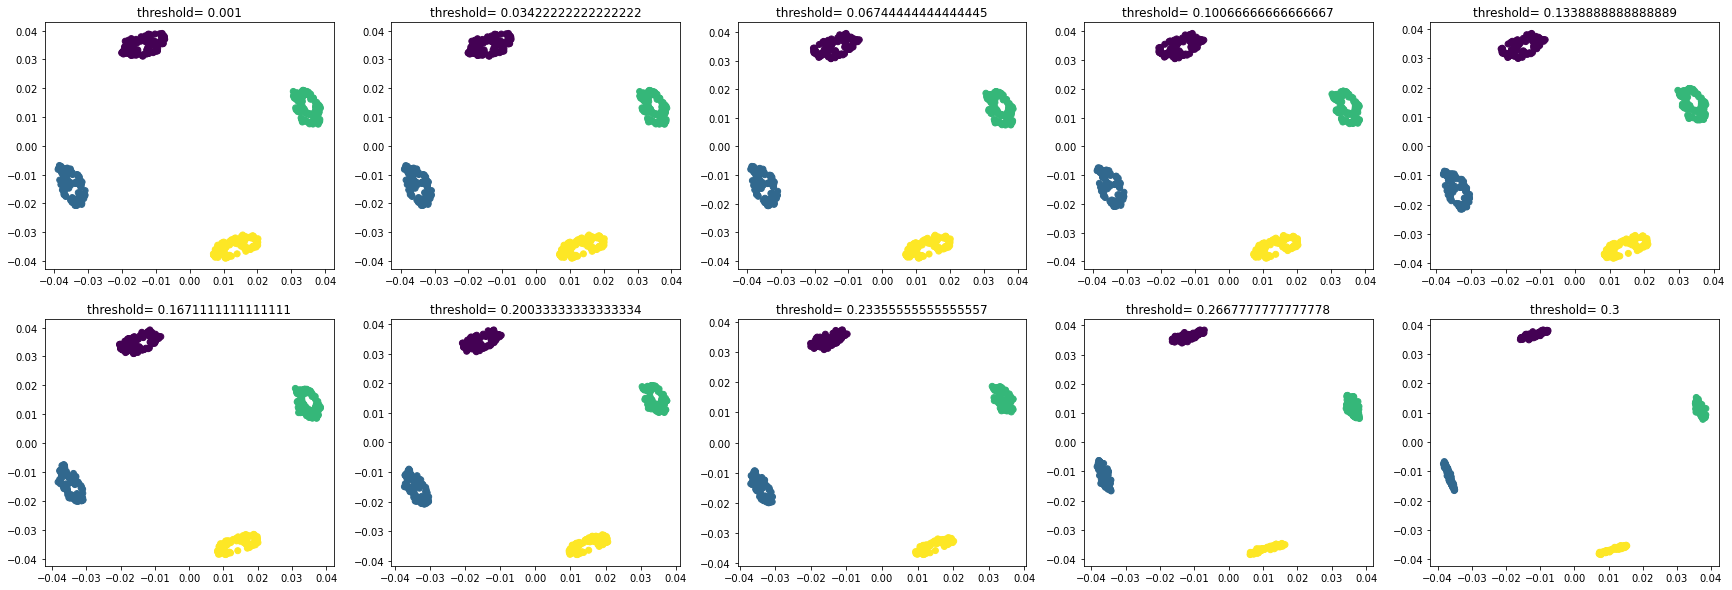

In [15]:
# plot a figure with different values of harnack regularization.
truncation_type = "dist_truncation"
treshold_type = "min"
truncation_arg = np.linspace(0.001,0.3,10)
n = len(truncation_arg)
fig, ax = plt.subplots(nrows=2, ncols=int(n/2), figsize=(30, 10))
ax = ax.flatten()
for i in range(n):
    emb_op = new_HeatGeo(knn=5,harnack_regul=0, tau="auto", truncation_type=truncation_type, truncation_arg=truncation_arg[i], treshold_type=treshold_type)
    emb = emb_op.fit_transform(data)
    ax[i].scatter(emb[:,0],emb[:,1],c=labels)
    ax[i].set_title("threshold= {}".format(truncation_arg[i]))
    # ax[i].axis("off")



/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]


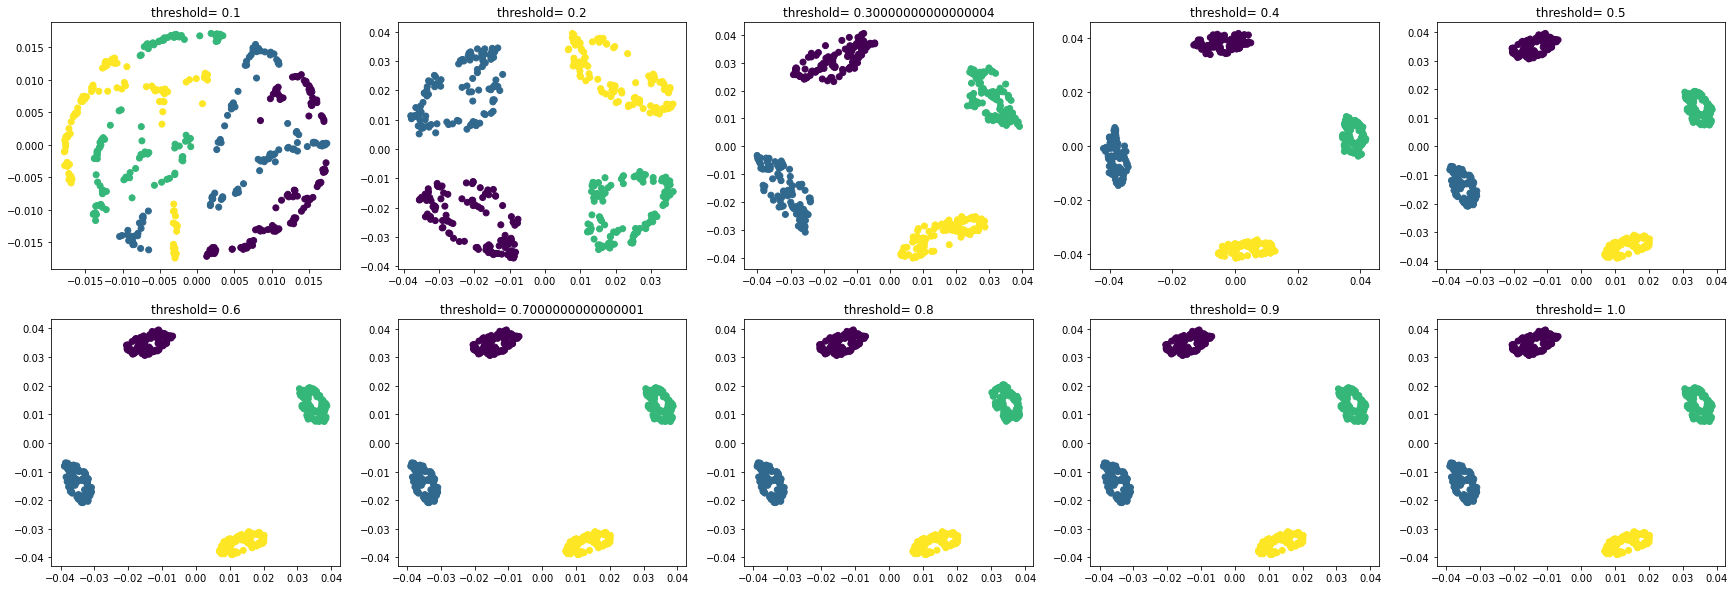

In [18]:
truncation_type = "dist_truncation"
treshold_type = "max"
truncation_arg = np.linspace(0.1,1,10)
n = len(truncation_arg)
fig, ax = plt.subplots(nrows=2, ncols=int(n/2), figsize=(30, 10))
ax = ax.flatten()
for i in range(n):
    emb_op = new_HeatGeo(knn=5,harnack_regul=0, tau="auto", truncation_type=truncation_type, truncation_arg=truncation_arg[i], treshold_type=treshold_type)
    emb = emb_op.fit_transform(data)
    ax[i].scatter(emb[:,0],emb[:,1],c=labels)
    ax[i].set_title("threshold= {}".format(truncation_arg[i]))
    # ax[i].axis("off")

/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


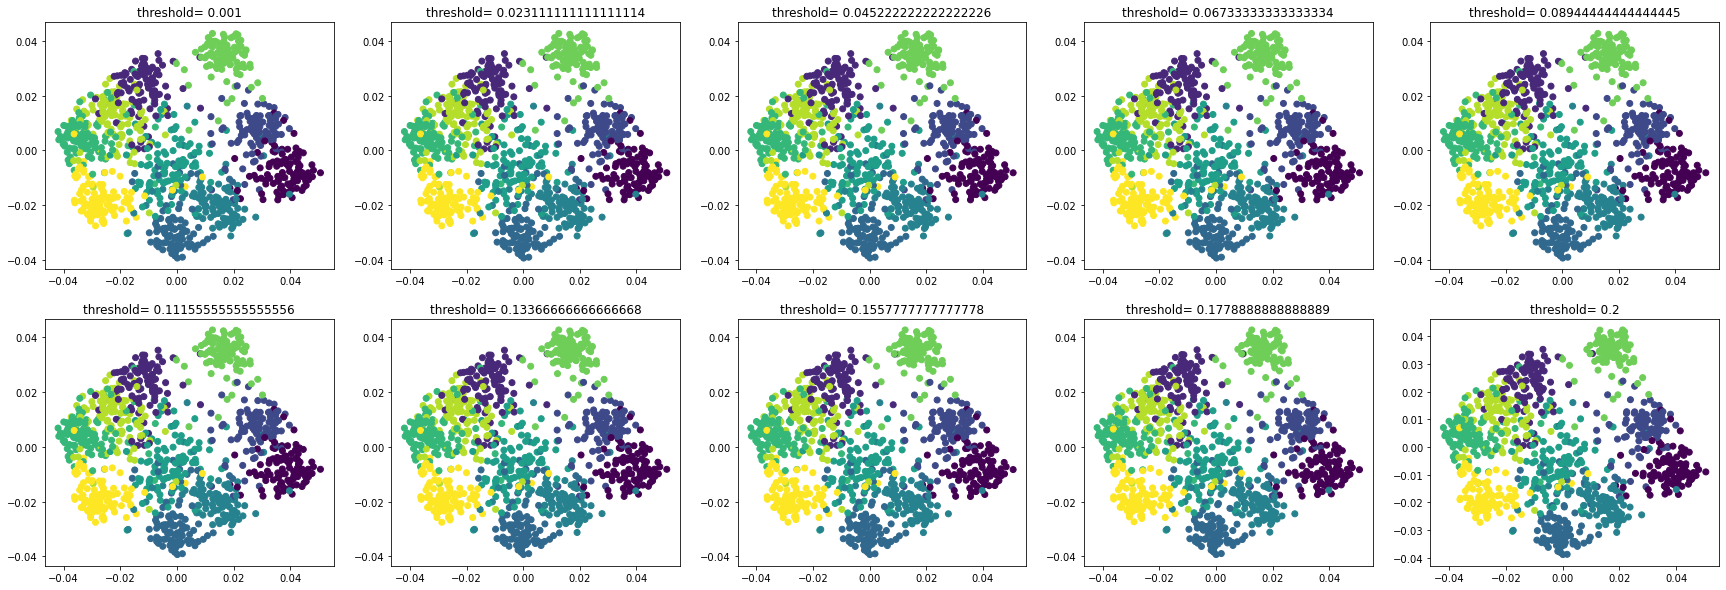

In [22]:
data,labels = datasets.make_blobs(n_samples=1000,n_features=10, centers=10, random_state=52, cluster_std=5)
truncation_type = "dist_truncation"
treshold_type = "min"
truncation_arg = np.linspace(0.001,0.2,10)
n = len(truncation_arg)
fig, ax = plt.subplots(nrows=2, ncols=int(n/2), figsize=(30, 10))
ax = ax.flatten()
for i in range(n):
    emb_op = new_HeatGeo(knn=5,harnack_regul=0, tau="auto", truncation_type=truncation_type, truncation_arg=truncation_arg[i], treshold_type=treshold_type)
    emb = emb_op.fit_transform(data)
    ax[i].scatter(emb[:,0],emb[:,1],c=labels)
    ax[i].set_title("threshold= {}".format(truncation_arg[i]))
    # ax[i].axis("off")


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


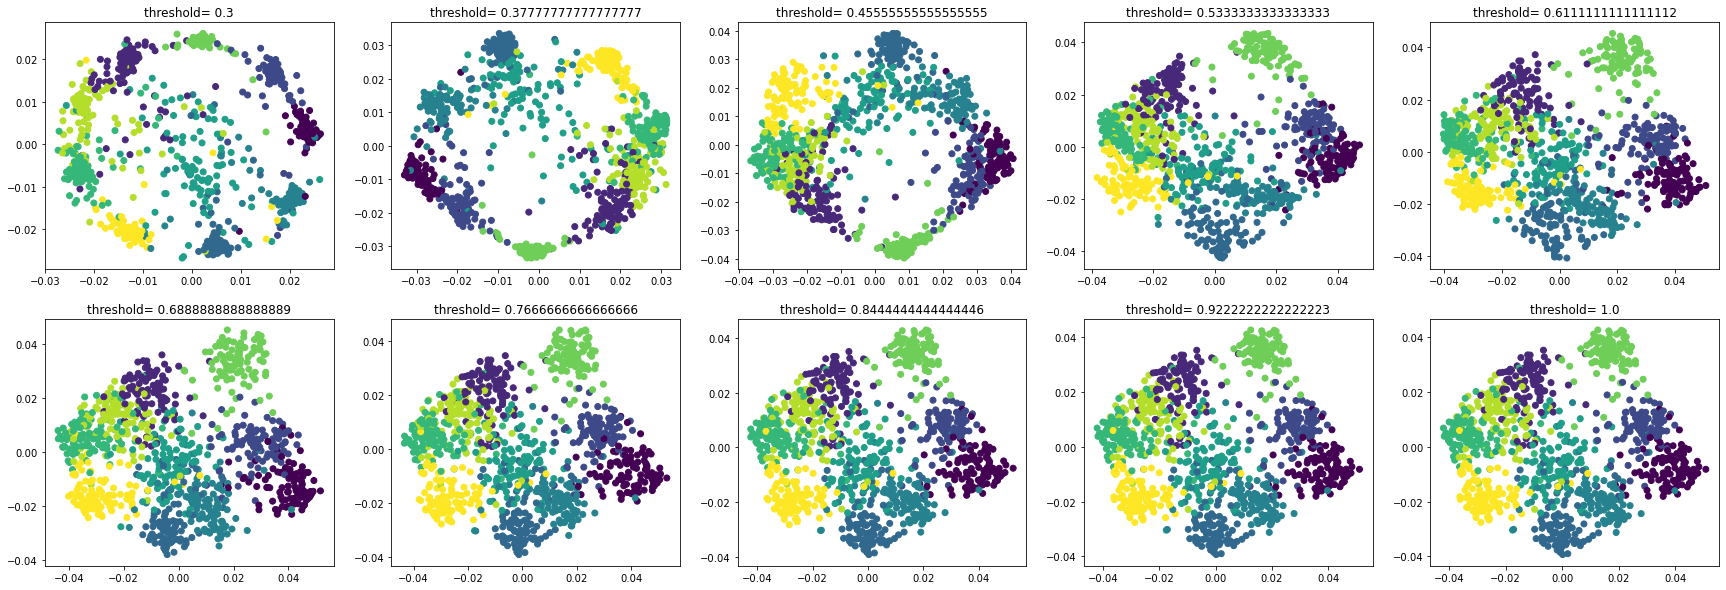

In [41]:
data, labels = datasets.make_blobs(n_samples=1000,n_features=10, centers=10, random_state=52, cluster_std=5)
truncation_type = "dist_truncation"
treshold_type = "max"
truncation_arg = np.linspace(0.3,1,10)
n = len(truncation_arg)
fig, ax = plt.subplots(nrows=2, ncols=int(n/2), figsize=(30, 10))
ax = ax.flatten()
for i in range(n):
    emb_op = new_HeatGeo(knn=5,harnack_regul=0, tau="auto", truncation_type=truncation_type, truncation_arg=truncation_arg[i], treshold_type=treshold_type)
    emb = emb_op.fit_transform(data)
    ax[i].scatter(emb[:,0],emb[:,1],c=labels)
    ax[i].set_title("threshold= {}".format(truncation_arg[i]))
    # ax[i].axis("off")

/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


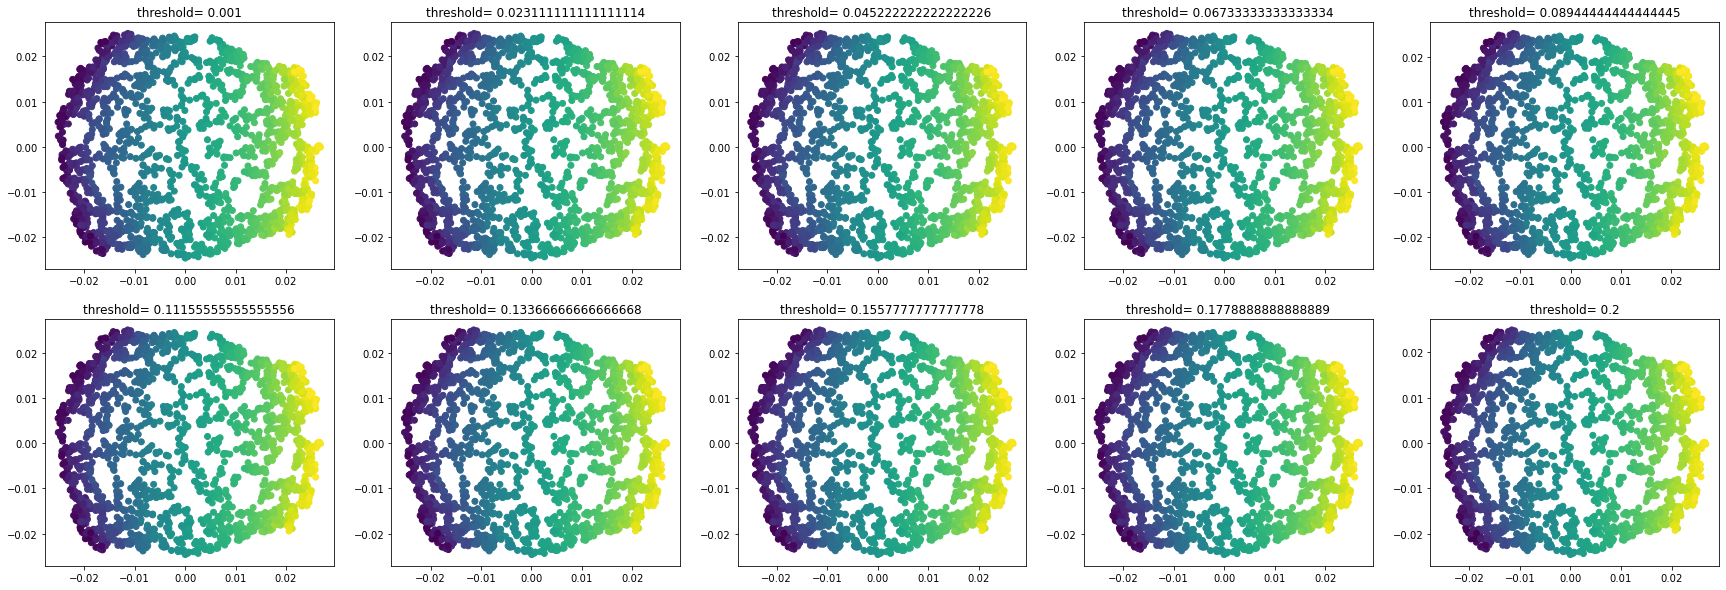

In [25]:
np.random.seed(42)
x, t = datasets.make_swiss_roll(
    2000,
)
x[:, 1] *= 3
data, labels = x, t 
truncation_type = "dist_truncation"
treshold_type = "min"
truncation_arg = np.linspace(0.001,0.2,10)
n = len(truncation_arg)
fig, ax = plt.subplots(nrows=2, ncols=int(n/2), figsize=(30, 10))
ax = ax.flatten()
for i in range(n):
    emb_op = new_HeatGeo(knn=5,harnack_regul=0, tau="auto", truncation_type=truncation_type, truncation_arg=truncation_arg[i], treshold_type=treshold_type)
    emb = emb_op.fit_transform(data)
    ax[i].scatter(emb[:,0],emb[:,1],c=labels)
    ax[i].set_title("threshold= {}".format(truncation_arg[i]))
    # ax[i].axis("off")

/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3
  warnings.warn(


Optimal tau:  [22.26666667]


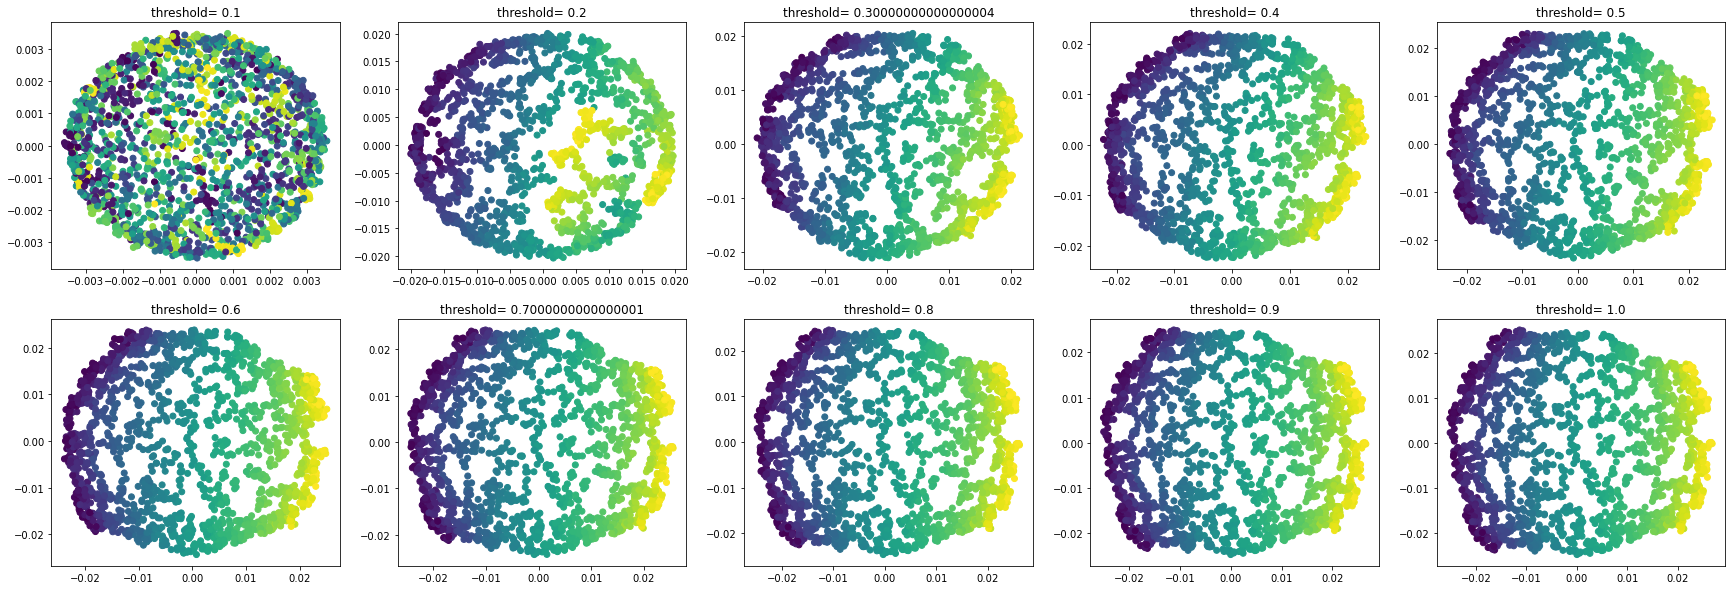

In [26]:
truncation_type = "dist_truncation"
treshold_type = "max"
truncation_arg = np.linspace(0.1,1,10)
n = len(truncation_arg)
fig, ax = plt.subplots(nrows=2, ncols=int(n/2), figsize=(30, 10))
ax = ax.flatten()
for i in range(n):
    emb_op = new_HeatGeo(knn=5,harnack_regul=0, tau="auto", truncation_type=truncation_type, truncation_arg=truncation_arg[i], treshold_type=treshold_type)
    emb = emb_op.fit_transform(data)
    ax[i].scatter(emb[:,0],emb[:,1],c=labels)
    ax[i].set_title("threshold= {}".format(truncation_arg[i]))
    # ax[i].axis("off")

/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


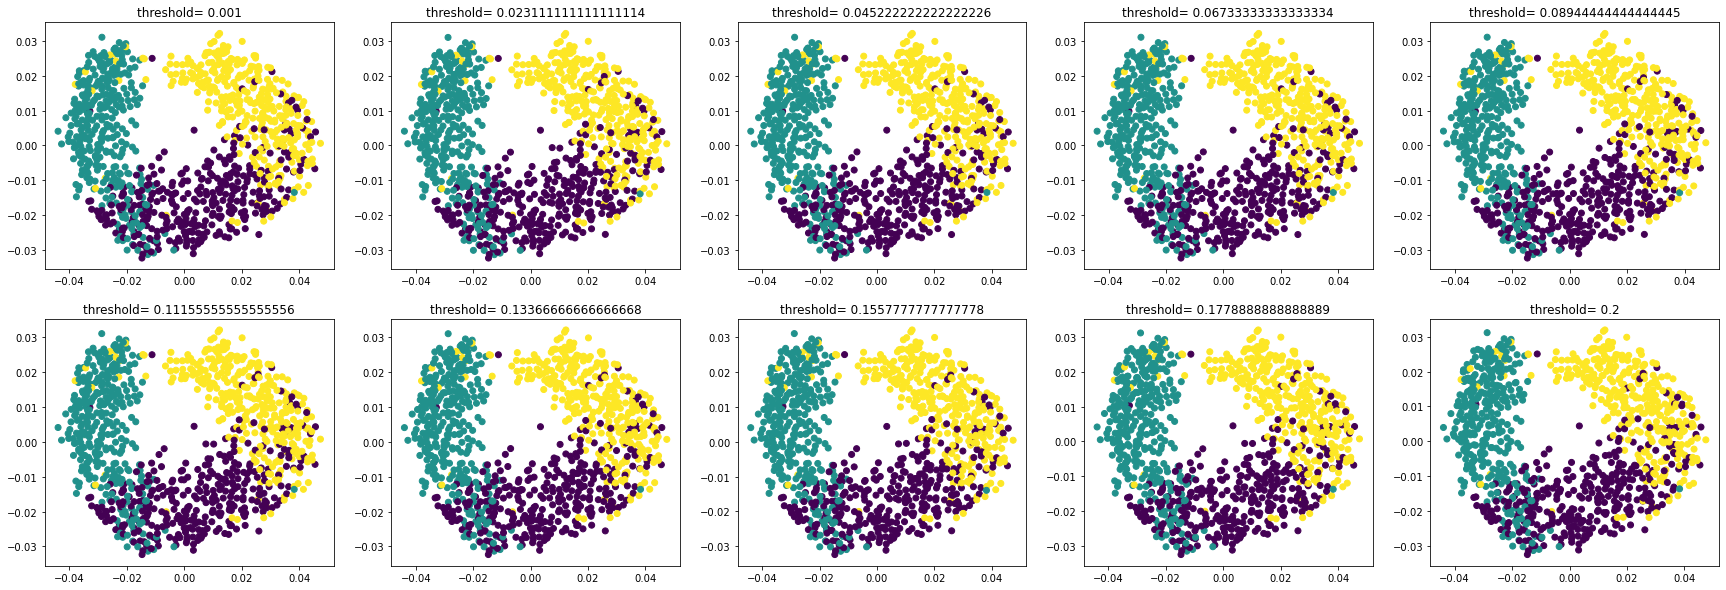

In [29]:
data, labels = datasets.make_classification(n_samples=1000, n_features=10, n_classes=3, random_state=42, n_clusters_per_class=1, n_informative=2)
truncation_type = "dist_truncation"
treshold_type = "min"
truncation_arg = np.linspace(0.001,0.2,10)
n = len(truncation_arg)
fig, ax = plt.subplots(nrows=2, ncols=int(n/2), figsize=(30, 10))
ax = ax.flatten()
for i in range(n):
    emb_op = new_HeatGeo(knn=5,harnack_regul=0, tau="auto", truncation_type=truncation_type, truncation_arg=truncation_arg[i], treshold_type=treshold_type)
    emb = emb_op.fit_transform(data)
    ax[i].scatter(emb[:,0],emb[:,1],c=labels)
    ax[i].set_title("threshold= {}".format(truncation_arg[i]))
    # ax[i].axis("off")

/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


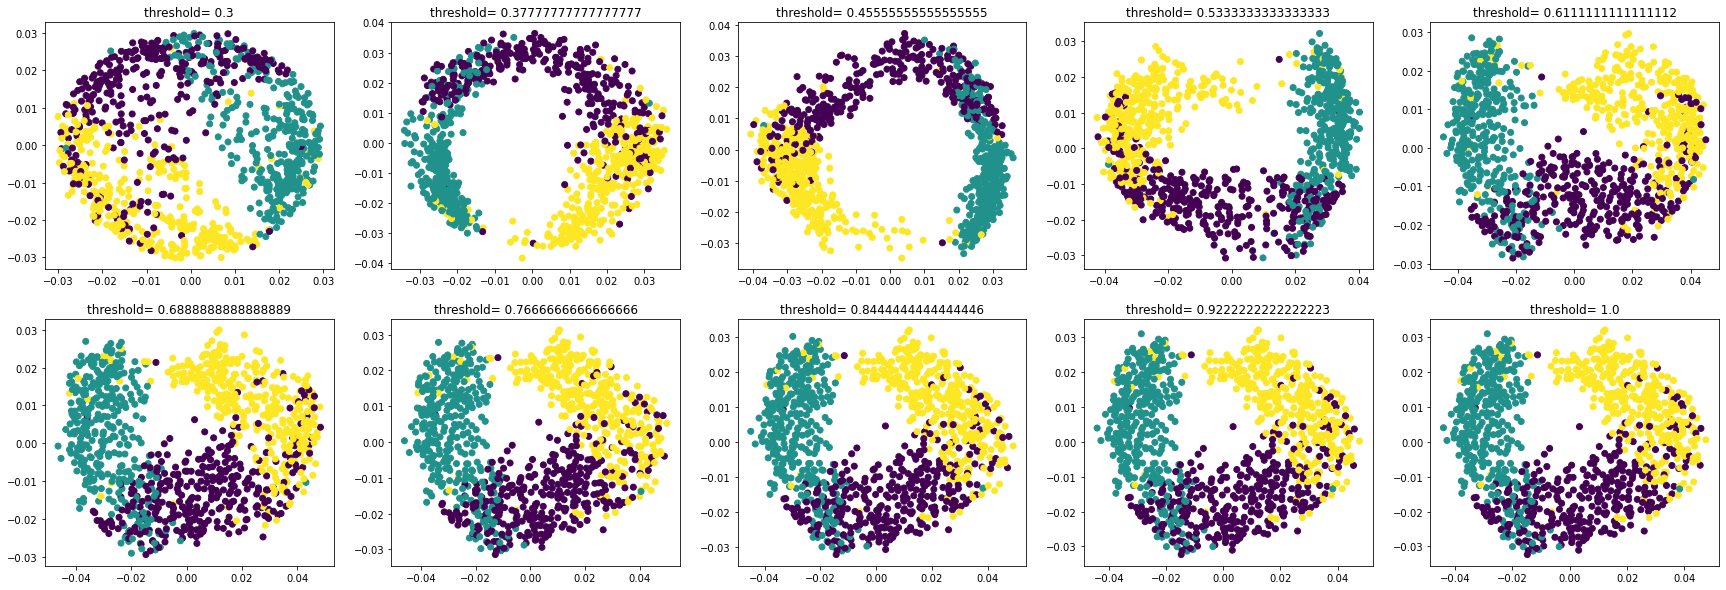

In [32]:
truncation_type = "dist_truncation"
treshold_type = "max"
truncation_arg = np.linspace(0.3,1,10)
n = len(truncation_arg)
fig, ax = plt.subplots(nrows=2, ncols=int(n/2), figsize=(30, 10))
ax = ax.flatten()
for i in range(n):
    emb_op = new_HeatGeo(knn=5,harnack_regul=0, tau="auto", truncation_type=truncation_type, truncation_arg=truncation_arg[i], treshold_type=treshold_type)
    emb = emb_op.fit_transform(data)
    ax[i].scatter(emb[:,0],emb[:,1],c=labels)
    ax[i].set_title("threshold= {}".format(truncation_arg[i]))
    # ax[i].axis("off")

In [42]:
import scanpy as sc
pbmc = sc.datasets.pbmc3k_processed()
data = pbmc.X
labels = pbmc.obs["louvain"]
labels = labels.replace(to_replace=['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
value=[0,1,2,3,4,5,6,7]
)

Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]


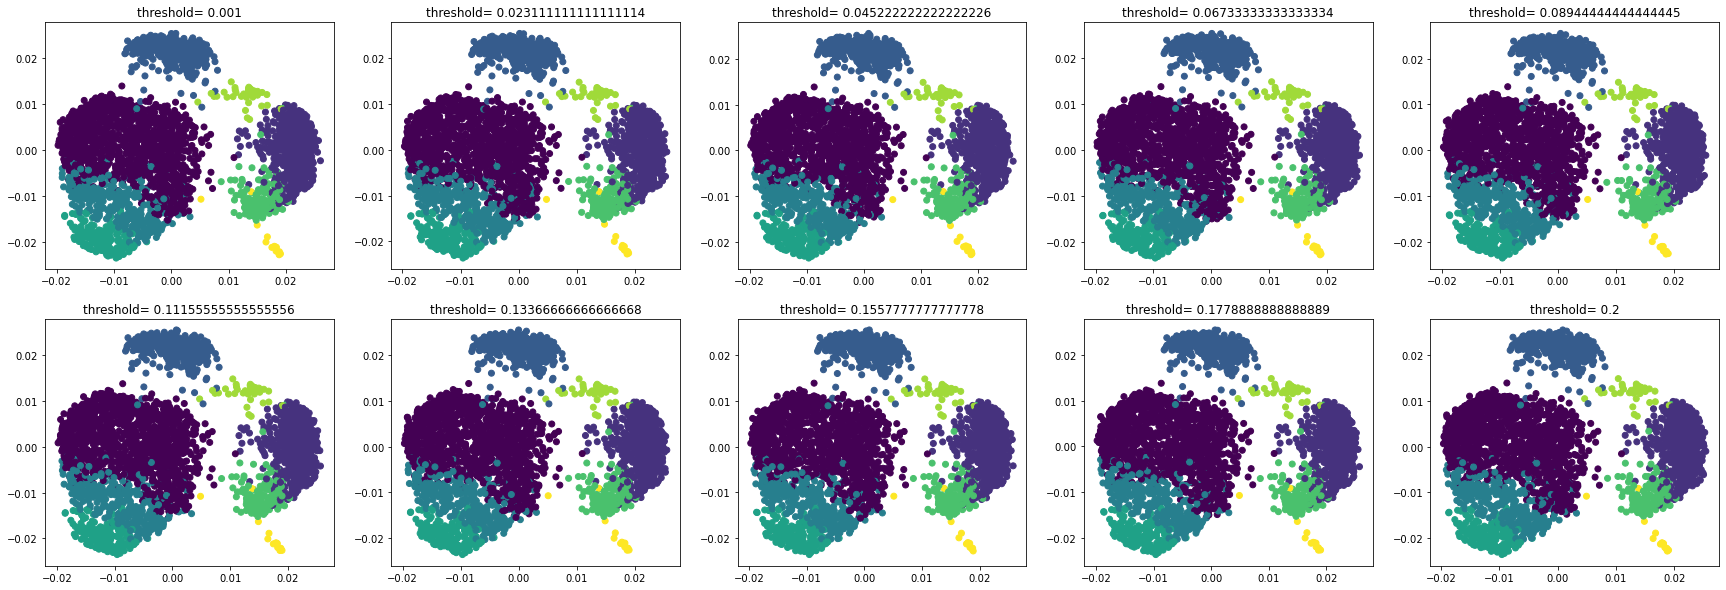

In [38]:
truncation_type = "dist_truncation"
treshold_type = "min"
truncation_arg = np.linspace(0.001,0.2,10)
n = len(truncation_arg)
fig, ax = plt.subplots(nrows=2, ncols=int(n/2), figsize=(30, 10))
ax = ax.flatten()
for i in range(n):
    emb_op = new_HeatGeo(knn=5,harnack_regul=0, tau="auto", truncation_type=truncation_type, truncation_arg=truncation_arg[i], treshold_type=treshold_type)
    emb = emb_op.fit_transform(data)
    ax[i].scatter(emb[:,0],emb[:,1],c=labels)
    ax[i].set_title("threshold= {}".format(truncation_arg[i]))
    # ax[i].axis("off")

Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]
Optimal tau:  [22.26666667]


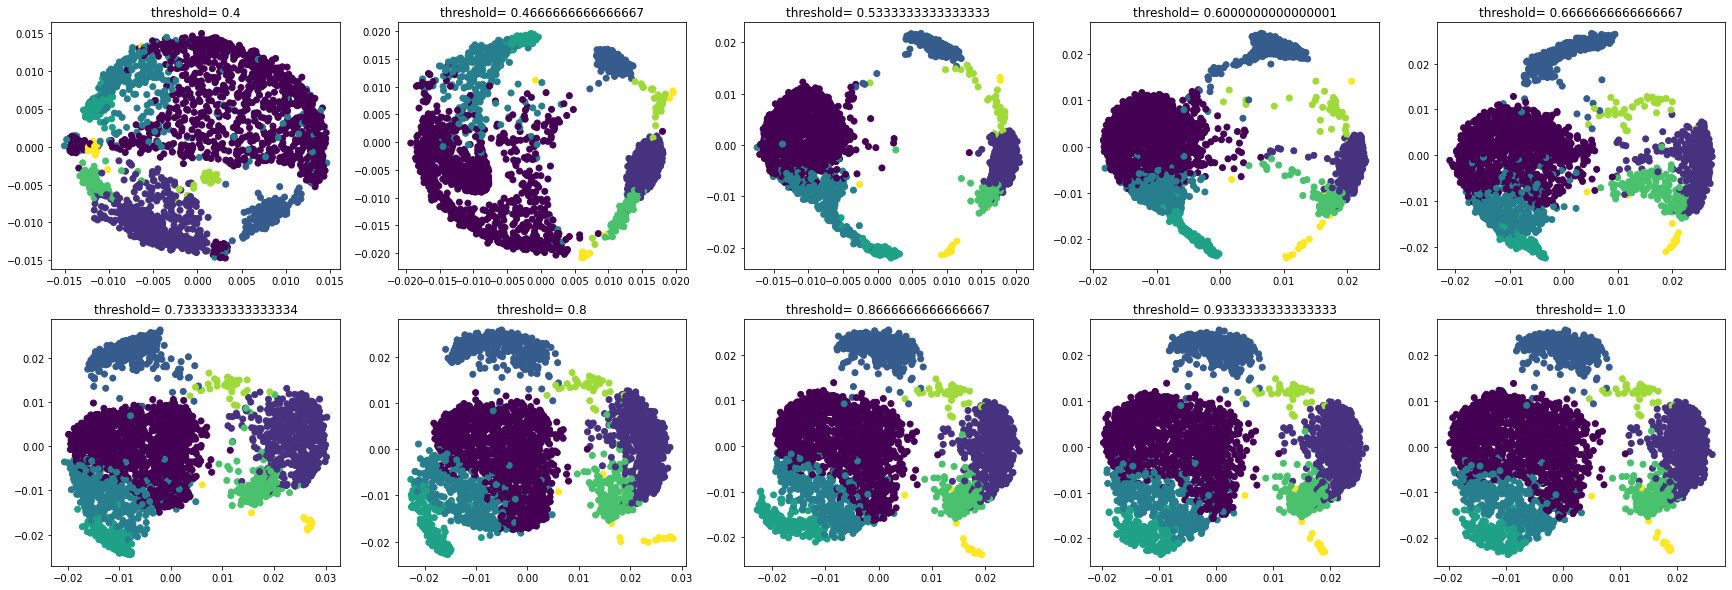

In [46]:
truncation_type = "dist_truncation"
treshold_type = "max"
truncation_arg = np.linspace(0.40,1,10)
n = len(truncation_arg)
fig, ax = plt.subplots(nrows=2, ncols=int(n/2), figsize=(30, 10))
ax = ax.flatten()
for i in range(n):
    emb_op = new_HeatGeo(knn=5,harnack_regul=0, tau="auto", truncation_type=truncation_type, truncation_arg=truncation_arg[i], treshold_type=treshold_type)
    emb = emb_op.fit_transform(data)
    ax[i].scatter(emb[:,0],emb[:,1],c=labels)
    ax[i].set_title("threshold= {}".format(truncation_arg[i]))
    # ax[i].axis("off")

/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


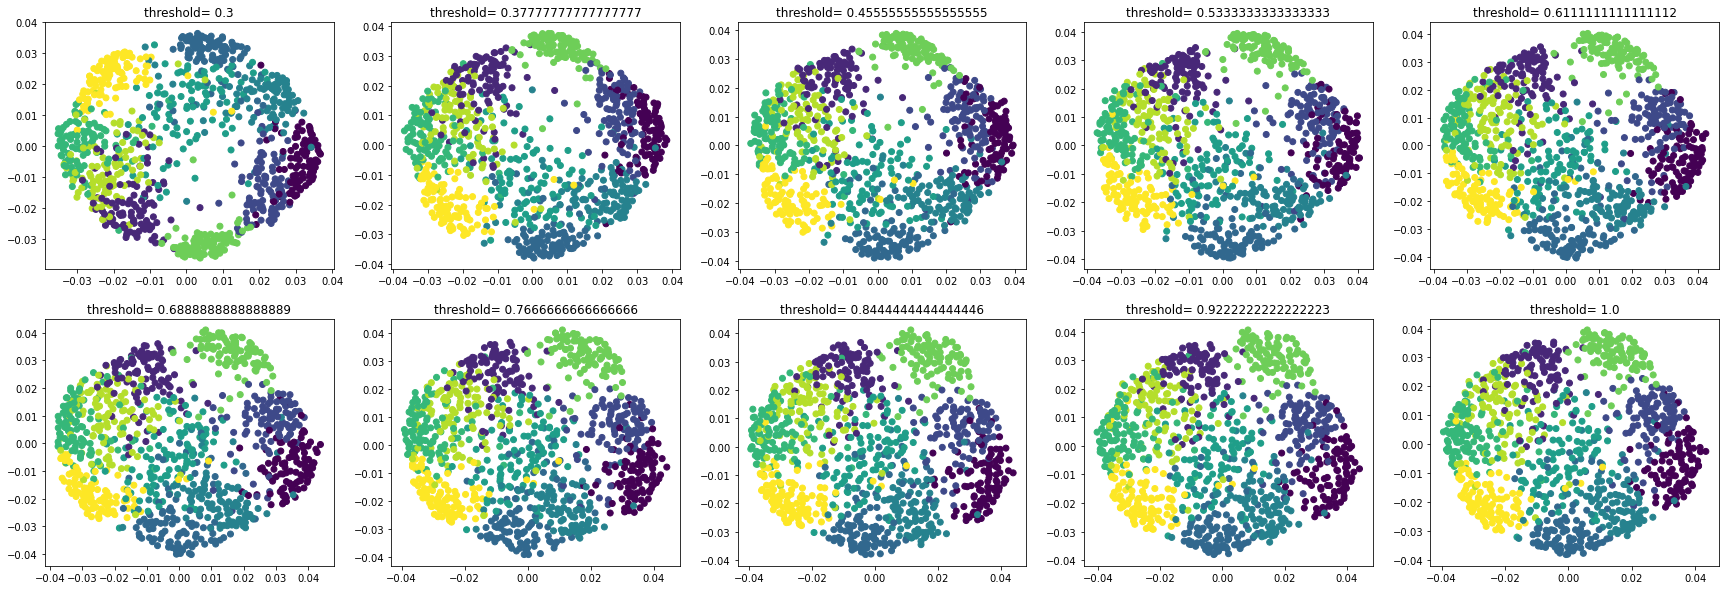

In [49]:
data, labels = datasets.make_blobs(n_samples=1000,n_features=10, centers=10, random_state=52, cluster_std=5)
truncation_type = "dist_truncation"
treshold_type = "max"
truncation_arg = np.linspace(0.3,1,10)
n = len(truncation_arg)
fig, ax = plt.subplots(nrows=2, ncols=int(n/2), figsize=(30, 10))
ax = ax.flatten()
for i in range(n):
    emb_op = new_HeatGeo(knn=5,harnack_regul=0, tau="auto", truncation_type=truncation_type, truncation_arg=truncation_arg[i], treshold_type=treshold_type,norm_treshold=False)
    emb = emb_op.fit_transform(data)
    ax[i].scatter(emb[:,0],emb[:,1],c=labels)
    ax[i].set_title("threshold= {}".format(truncation_arg[i]))
    # ax[i].axis("off")

/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]


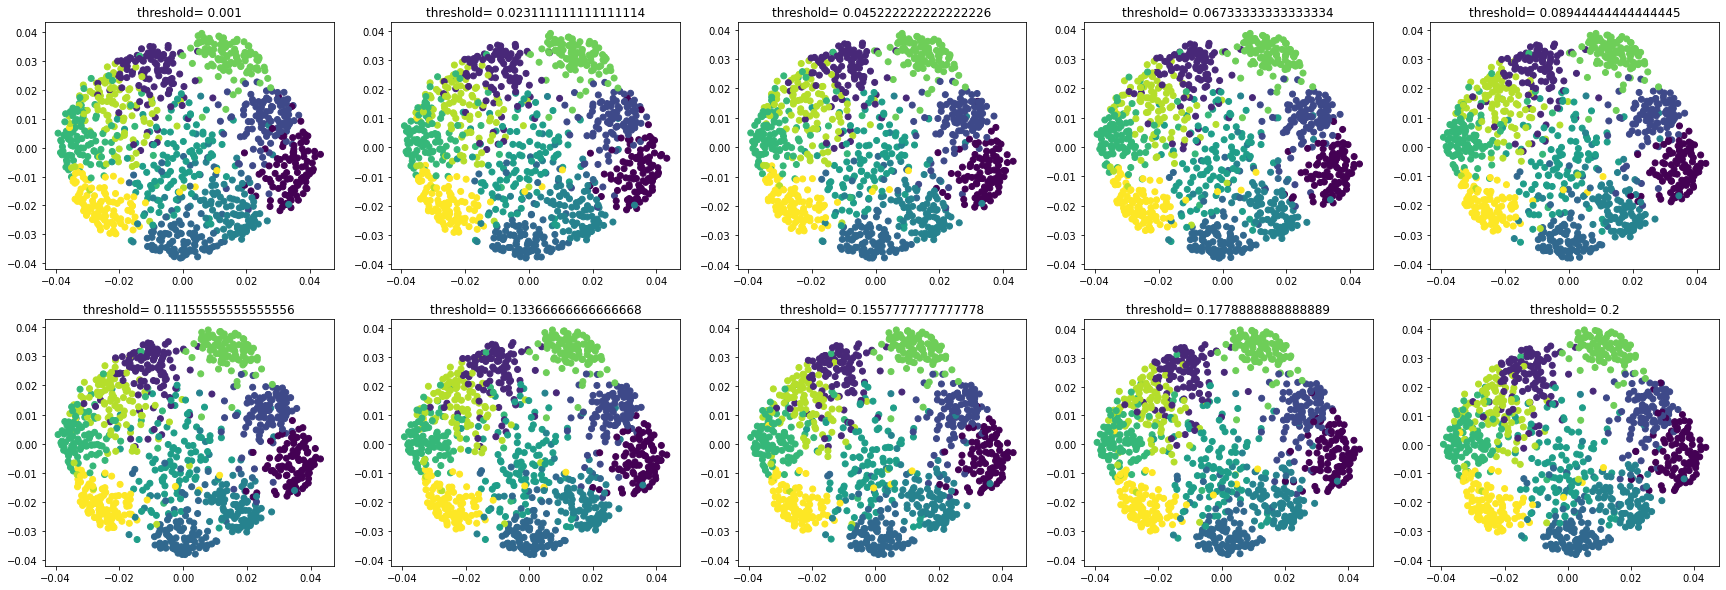

In [51]:
data, labels = datasets.make_blobs(n_samples=1000,n_features=10, centers=10, random_state=52, cluster_std=5)
truncation_type = "dist_truncation"
treshold_type = "min"
truncation_arg = np.linspace(0.001,0.2,10)
n = len(truncation_arg)
fig, ax = plt.subplots(nrows=2, ncols=int(n/2), figsize=(30, 10))
ax = ax.flatten()
for i in range(n):
    emb_op = new_HeatGeo(knn=5,harnack_regul=0, tau="auto", truncation_type=truncation_type, truncation_arg=truncation_arg[i], treshold_type=treshold_type,norm_treshold=False)
    emb = emb_op.fit_transform(data)
    ax[i].scatter(emb[:,0],emb[:,1],c=labels)
    ax[i].set_title("threshold= {}".format(truncation_arg[i]))
    # ax[i].axis("off")